# Code for fitting Astero RC data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
sns.set_palette('colorblind',20)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
matplotlib.rc('axes',labelsize=15) 
matplotlib.rc("text", usetex=True)
import pandas as pd
import pystan

import os
import pickle

import sys

__outdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/Output/'
__datdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/data/KepxDR2/'

In [2]:
def read_data(data_file=''):
    if data_file == '':
        sfile = '../data/KepxDR2/rcxyu18.csv'
    elif data_file != '':
        sfile = data_file
    df = pd.read_csv(sfile)
    return df

def get_bcs(tempdiff):
    BCs = pd.read_csv(__datdir__+'BCs/Logg_perturbed/casagrande_bcs_'+str(tempdiff)+'.csv')

    return BCs


In [3]:
df = read_data()
print('Size: '+str(len(df)))
df.head(2)

Size: 5570


,KICID,kepmag_x,Length_Quarters,Length_days,numax,numax_err,dnu,dnu_err,amplitude,err.2_x,...,Ebv,Aks,Aj,Ah,H17_Ag,L,L_err,Mbol,Mbol_err,Z
0,892760,13.23,6,380.8,29.48,0.48,3.962,0.116,149.7,8.3,...,0.090092,0.016483,0.066545,0.033477,0.256763,72.126040,13.744428,0.10477,0.206899,0.010827
1,1026084,12.14,15,1139.0,41.17,0.90,4.414,0.061,63.8,2.9,...,0.082530,0.015099,0.060960,0.030667,0.235211,81.549973,12.518103,-0.02856,0.166663,0.013321


In [5]:
tempdiff = -50.0
band = 'K'
BCs = get_bcs(tempdiff)
df = pd.merge(df, BCs, how='left', on='KICID')

bcerr = 0.02 # We assume an error of 0.02mag on the bolometric correction (roughly 1 to 2 %)
Mobs = df.Mbol - df['BC_'+band]
Munc = np.sqrt(df.Mbol_err**2 + bcerr**2)

## Stan model for asteroseismic values

In [7]:
overwrite = False
asterostan = '''
data {
    int<lower = 0> N;
    real Mobs[N];
    real Munc[N];
}
parameters {
    //Hyperparameters
    real mu;
    real <lower=0.> sigma;
    real <lower=0.5,upper=1.> Q;
    real <lower=1.> sigo;

    //Latent Parameters
    real Mtrue_std[N];
}
transformed parameters{
    real Mtrue[N];
    
    for (n in 1:N){
        Mtrue[n] = mu + sigma * Mtrue_std[n];
    }
}
model {
    mu ~ normal(-1.6, 1.0);  //p(theta)
    sigma ~ normal(0.0, 1.0); //''
    sigo ~ normal(3.0, 2.0);  //''
    Q ~ normal(1., 0.1);    //''  
    
    Mobs ~ normal(Mtrue, Munc); //p(D | theta, alpha)
    
    //p(alpha | theta)
    for (n in 1:N)
        target += log_mix(Q,
                    normal_lpdf(Mtrue_std[n] | 0., 1.),
                    normal_lpdf(Mtrue_std[n] | 0., sigo));
}
'''
model_path = 'asterostan.pkl'
if overwrite:
    print('Updating Stan model')
    sm = pystan.StanModel(model_code = asterostan, model_name='asterostan')
    with open(model_path, 'wb') as f:
        pickle.dump(sm, f)
else:
    if os.path.isfile(model_path):
        print('Loading in existing Stan Model') 
        sm = pickle.load(open(model_path, 'rb'))
    else:
        print('Saving Stan Model') 
        sm = pystan.StanModel(model_code = asterostan, model_name='asterostan')
        with open(model_path, 'wb') as f:
            pickle.dump(sm, f)

Loading in existing Stan Model


ValueError: unsupported pickle protocol: 3

In [36]:
from omnitool.literature_values import hawkvals

In [79]:
dat = {'N':len(df), 'Mobs':Mobs, 'Munc':Munc, 'muH':hawkvals[band]}

#Set up initial guesses
from omnitool.literature_values import hawkvals
init = {'mu':hawkvals[band], 'sigma':0.1, 'Q':0.95, 'sigo':4.}

fit = sm.sampling(data=dat, iter=1000, chains=4, seed=24601, init=[init,init,init,init])

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


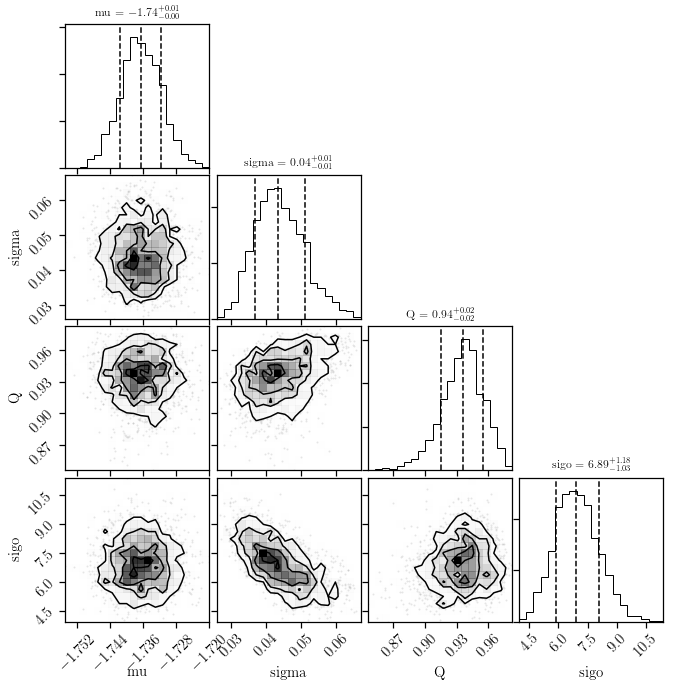

In [80]:
import corner
chain = np.array([fit['mu'],fit['sigma'],fit['Q'],fit['sigo']])
corner.corner(chain.T,labels=['mu','sigma','Q','sigo'],
                  quantiles=[0.16, 0.5, 0.84],\
                  show_titles=True, title_kwargs={"fontsize": 12})
plt.show()

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


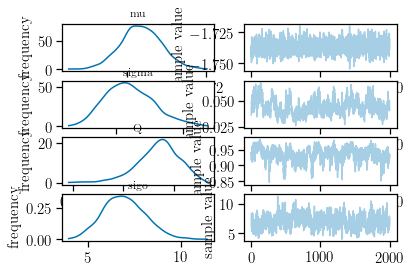

In [74]:
fit.plot(pars=['mu', 'sigma', 'Q', 'sigo'])
plt.show()

In [75]:
from pystan import diagnostics

In [76]:
out = fit.extract()
output = open('test.pkl', 'wb')
pickle.dump(out, output)
output.close()

In [10]:
import sys
sys.version

'2.7.15rc1 (default, Apr 15 2018, 21:51:34) \n[GCC 7.3.0]'

In [8]:
pkl_file = open('asterostan.pkl', 'rb')
d = pickle.load(pkl_file)
pkl_file.close()

ValueError: unsupported pickle protocol: 3

In [88]:
pkl_file = open('astero_-50.0_fullchain_dict.pkl', 'rb')
d = pickle.load(pkl_file)
pkl_file.close()

In [90]:
print(d)

OrderedDict([(u'mu', array([-1.70529849, -1.70633567, -1.70615563, ..., -1.70326767,
       -1.70181372, -1.70636021])), (u'sigma', array([0.0347276 , 0.03536052, 0.025973  , ..., 0.03123221, 0.0272148 ,
       0.03923571])), (u'Q', array([0.89152916, 0.87678058, 0.88562291, ..., 0.87616854, 0.88371556,
       0.89723052])), (u'sigo', array([ 8.85200898,  7.76463449, 11.18607124, ...,  8.92081837,
       10.61970978,  8.21502344])), (u'Mtrue_std', array([[-0.07207641, -5.8413646 , -0.19001396, ...,  0.56704902,
         0.11949594,  3.32298241],
       [-0.04693643, -4.1275176 , -0.89954936, ...,  0.72182634,
         2.67859872, -1.51286993],
       [ 0.35524754,  0.6616983 , -1.39968024, ..., -0.56905329,
         1.29690645,  1.61713046],
       ...,
       [-1.58964466, -1.46796502, -0.60348942, ..., -1.42078596,
        -0.67052499, -0.11546507],
       [ 0.20641794, -0.63215533, -0.75655561, ...,  0.97589951,
         0.77180899, -0.89362731],
       [ 0.05880646, -1.13200885,  0

In [78]:
print(fit)

Inference for Stan model: astrostan_04890be6ddbf993fa0f4c1d001122e81.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu               -1.74  1.3e-4 5.0e-3  -1.75  -1.74  -1.74  -1.73  -1.73 1482.0    1.0
sigma             0.04  1.0e-3 7.1e-3   0.03   0.04   0.04   0.05   0.06   49.0   1.08
Q                 0.93  2.3e-3   0.02   0.89   0.92   0.94   0.95   0.97   75.0   1.05
sigo              6.95    0.09   1.11    4.9   6.15   6.89   7.67   9.24  146.0   1.03
Mtrue_std[1]     -0.03    0.07   1.47  -2.55  -0.64   0.07   0.74   2.14  397.0   1.01
Mtrue_std[2]     -0.31    0.03    1.3  -2.76  -0.95  -0.26    0.4   1.91 1384.0    1.0
Mtrue_std[3]     -0.71    0.08   1.78  -6.09  -1.21  -0.47   0.19   1.62  514.0   1.01
Mtrue_std[4]       0.2    0.12    1.6  -2.05  -0.67   0.05   0.79   4.17  164.0   1.02
Mtrue_std[5]      0.45    0.04 

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


[1.00008738 1.00695752 1.00753221 ... 0.99985355 1.00002808 1.00975362]
Total number of Rhats: 2005
Total number of Rhats with the NaN values removed: 2005


INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


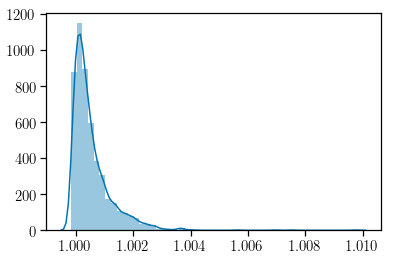

In [41]:
s = fit.summary()
print(s['summary'][:,-1])
rhat = s['summary'][:,-1]
rhatfin = rhat[np.isfinite(rhat)]
print('Total number of Rhats: '+str(len(rhat)))
print('Total number of Rhats with the NaN values removed: '+str(len(rhatfin)))
sns.distplot(rhatfin)
plt.show()

### Some diagnostic plots

In [11]:
mu = np.median(fit['mu'])
sigma = np.median(fit['sigma'])
sigo = np.median(fit['sigo'])*sigma
Q = np.median(fit['Q'])
Mtrue = np.median(fit['Mtrue'],axis=0)

x = np.linspace(Mobs.min(), Mobs.max(),1000)
fg = normal(x, mu, sigma)
bg = normal(x, mu, sigo)
L = Q*fg + (1-Q)*bg

Text(0,0.5,u'Units arbitrary')

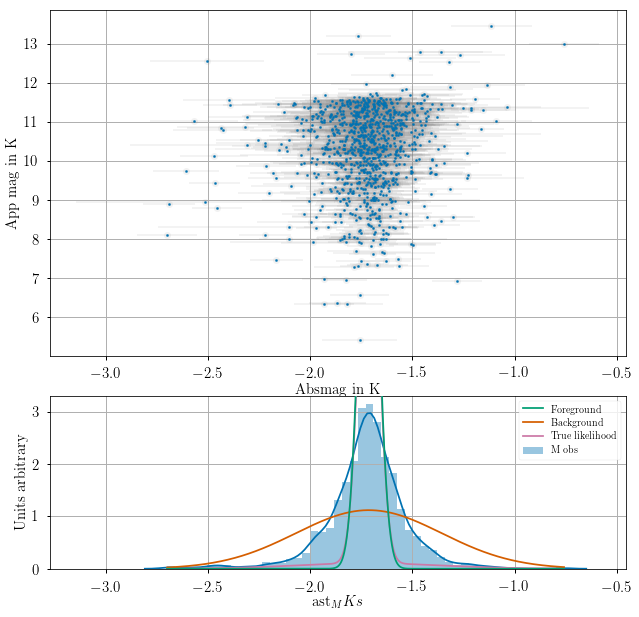

In [12]:
left, bottom, width, height = 0.1, 0.47, 1., 0.60
fig = plt.figure(1, figsize=(8,8))
sax = fig.add_axes([left, bottom, width, height])
xax = fig.add_axes([left, 0.1, width, 0.3],sharex=sax)

sax.scatter(Mobs,m,s=5,zorder=1000)
sax.errorbar(Mobs,m,xerr=Munc,c='grey',fmt='o',alpha=.1,zorder=999)

sns.distplot(Mobs, ax=xax, label='M obs')
xax.plot(x,fg,label='Foreground',zorder=999)
xax.plot(x,bg,label='Background',zorder=998)
xax.plot(x, L,label='True likelihood',zorder=997)
xax.legend()

sax.grid()
xax.grid()

sax.set_xlabel('Absmag in K')
sax.set_ylabel('App mag in K')
xax.set_ylabel('Units arbitrary')

Text(0,0.5,u'Units arbitrary')

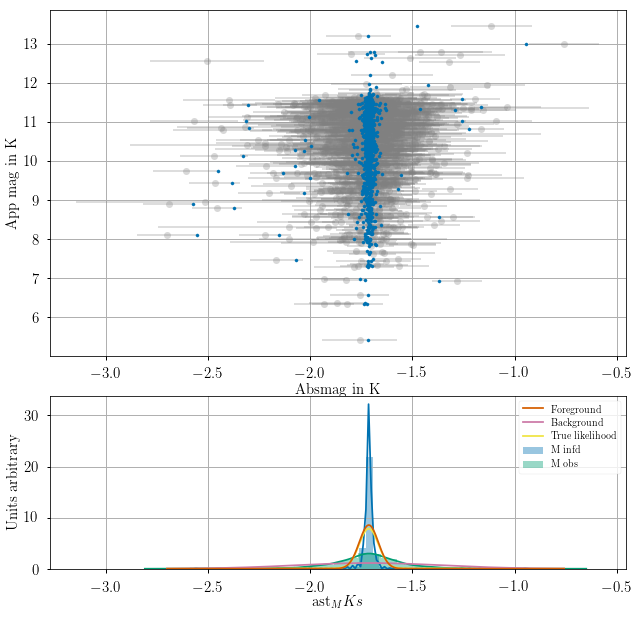

In [13]:
left, bottom, width, height = 0.1, 0.47, 1., 0.60
fig = plt.figure(1, figsize=(8,8))
sax = fig.add_axes([left, bottom, width, height])
xax = fig.add_axes([left, 0.1, width, 0.3],sharex=sax)

sax.scatter(Mtrue,m,s=10,zorder=1000)
sax.errorbar(Mobs,m,xerr=Munc,c='grey',fmt='o',alpha=.3,zorder=999)

sns.distplot(Mtrue, ax=xax, label='M infd')
sns.distplot(Mobs, ax=xax, label='M obs')
xax.plot(x,fg,label='Foreground',zorder=999)
xax.plot(x,bg,label='Background',zorder=998)
xax.plot(x, L,label='True likelihood',zorder=997)
xax.legend()

sax.grid()
xax.grid()

sax.set_xlabel('Absmag in K')
sax.set_ylabel('App mag in K')
xax.set_ylabel('Units arbitrary')

Text(0,0.5,u'Units arbitrary')

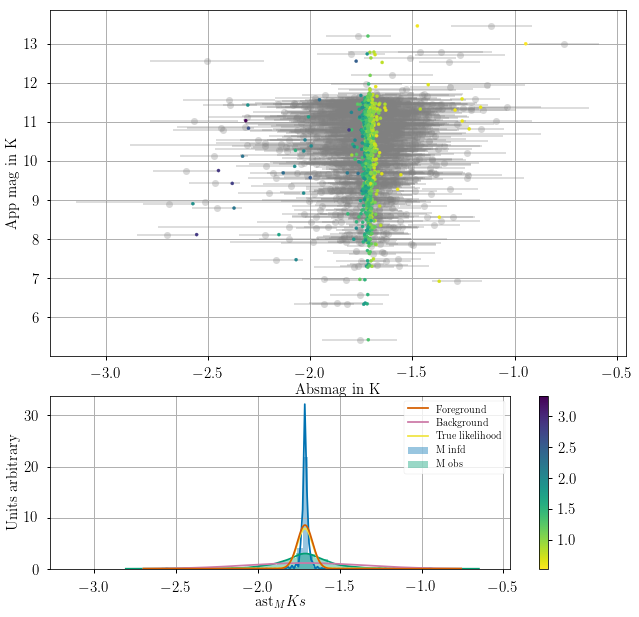

In [18]:
left, bottom, width, height = 0.1, 0.47, 1., 0.60
fig = plt.figure(1, figsize=(8,8))
sax = fig.add_axes([left, bottom, width, height])
xax = fig.add_axes([left, 0.1, width, 0.3],sharex=sax)

c = sax.scatter(Mtrue,m,s=10,c=sel.M_noCorrection,cmap='viridis_r',zorder=1000)
sax.errorbar(Mobs,m,xerr=Munc,c='grey',fmt='o',alpha=.3,zorder=999)

sns.distplot(Mtrue, ax=xax, label='M infd')
sns.distplot(Mobs, ax=xax, label='M obs')
xax.plot(x,fg,label='Foreground',zorder=999)
xax.plot(x,bg,label='Background',zorder=998)
xax.plot(x, L,label='True likelihood',zorder=997)
xax.legend()

sax.grid()
xax.grid()
fig.colorbar(c)

sax.set_xlabel('Absmag in K')
sax.set_ylabel('App mag in K')
xax.set_ylabel('Units arbitrary')

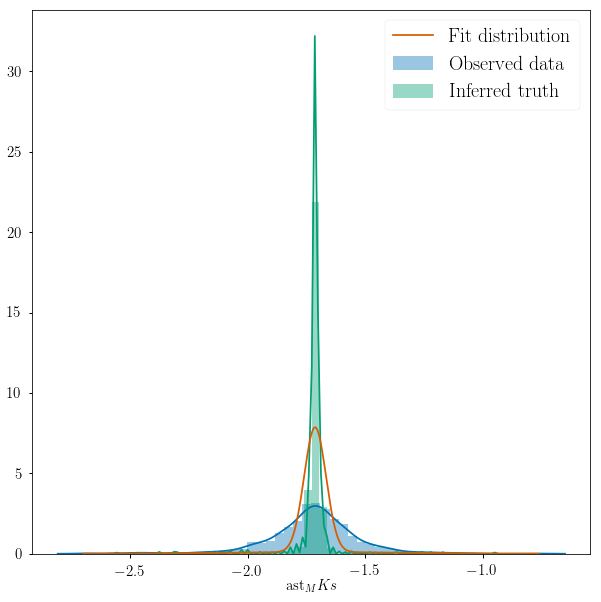

In [14]:
fig = plt.figure(figsize=(10,10))
sns.distplot(Mobs, label='Observed data')
sns.distplot(Mtrue, label='Inferred truth')
plt.plot(x, L, label='Fit distribution')
plt.legend(fontsize=20)
plt.show()

In [15]:
sys.exit()

SystemExit: 

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2886: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Other useful code

In [ ]:
'''
generated quantities {
    vector[N] post_prob;
    vector[N] bg_pp;
    real ll_fg;
    real ll_bg;
    
    for (n in 1:N){
        ll_fg = log(Q) + normal_lpdf(M_true_std[n] | 0, 1);
        ll_bg = log(1-Q) + normal_lpdf(M_true_std[n] | 0, tsigo);
        post_prob[n] = exp(ll_fg - log_sum_exp(ll_fg, ll_bg));
        bg_pp[n] = exp(ll_bg - log_sum_exp(ll_fg, ll_bg));
    }
}
'''

In [ ]:
#Calculate recall vs precision for various Kass+Raftery94 cut off scales
'''Calculate the Kass+Raftery94 lnK values'''
lnK = np.log(post_prob) - np.log(bg_pp)

recall, precision = [], []
for lim in np.linspace(lnK.min(),lnK.max(),1000):
    mask = lnK > lim
    cheb_correct = len(Ks[mask][stage[mask]==2])
    cheb_total = len(Ks[stage==2])
    identified_total = len(Ks[mask])
    recall.append(float(cheb_correct)/float(cheb_total))
    try:
        precision.append(float(cheb_correct)/float(identified_total))
    except:
        precision.append(0.)
        
fig, ax = plt.subplots()
col = ax.scatter(recall, precision, c=np.linspace(lnK.min(),lnK.max(),1000),vmin=0.)
ax.axhline(0.9,c='r',label='0.9 precision')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.grid()
ax.set_axisbelow(True)
fig.colorbar(col, label='lnK cut-off point',extend='min')
plt.show()        


In [ ]:
left, bottom, width, height = 0.1, 0.47, 0.85, 0.60
fig = plt.figure(1, figsize=(8,8))
sax = fig.add_axes([left, bottom, width, height])
xax = fig.add_axes([left, 0.1, width, 0.3])

# cax = fig.add_axes([left+width+0.01, bottom, 0.05, height])

c = sax.scatter(M,m,s=5,c=post_prob,zorder=1000)
# fig.colorbar(c, cax=cax, label='Posterior Probability')
sax.errorbar(M,m,xerr=M_err,c='grey',fmt='none',alpha=.3,zorder=999)

sns.distplot(M,ax=xax)

xax.scatter(M,fg,s=3,label='Foreground', alpha=.5,c='orange',zorder=999)
xax.scatter(M,bg,s=3,label='Background', alpha=.5,c='red',zorder=998)
xax.scatter(M, L,s=3,label='True likelihood', alpha=.5,c='green',zorder=997)

sax.set_xlabel('Absmag in K')
sax.set_ylabel('App mag in K')
xax.set_ylabel('Units arbitrary')

In [ ]:
fig, (ax,ax2)  = plt.subplots(2,figsize=(10,10))
ax.scatter(M[~mask],m[~mask],s=5,c=post_prob[~mask],zorder=1000, label='Outliers')
fig.colorbar(c,ax=ax, label='Posterior Probability')
ax.errorbar(M[~mask],m[~mask],xerr=M_err[~mask],c='grey',fmt='none',alpha=.3,zorder=999,label='Unc')
ax.scatter(M[mask],m[mask],s=1,alpha=.1,c='r', label='Inliers')
ax.legend()

ax2.scatter(M[mask],m[mask],s=5,c=post_prob[mask],zorder=1000, label='Inliers')
fig.colorbar(c, ax = ax2, label='Posterior Probability')
ax2.errorbar(M[mask],m[mask],xerr=M_err[mask],c='grey',fmt='none',alpha=.3,zorder=999,label='Unc')
ax2.scatter(M[~mask],m[~mask],s=10,alpha=.5,c='r',label='Outliers')
ax2.legend()

ax.set_xlabel('Absmag in K')
ax.set_ylabel('App mag in K')
plt.show()

What the above plot indicates is that inlier stars are defined by uncertainty more than anything else, and that allt he outlier stars have uncertainties that end near a similar limit, whereas the inlier stars can be more spread out, so long as their uncertainties have a chance at placing them at the overdensity.